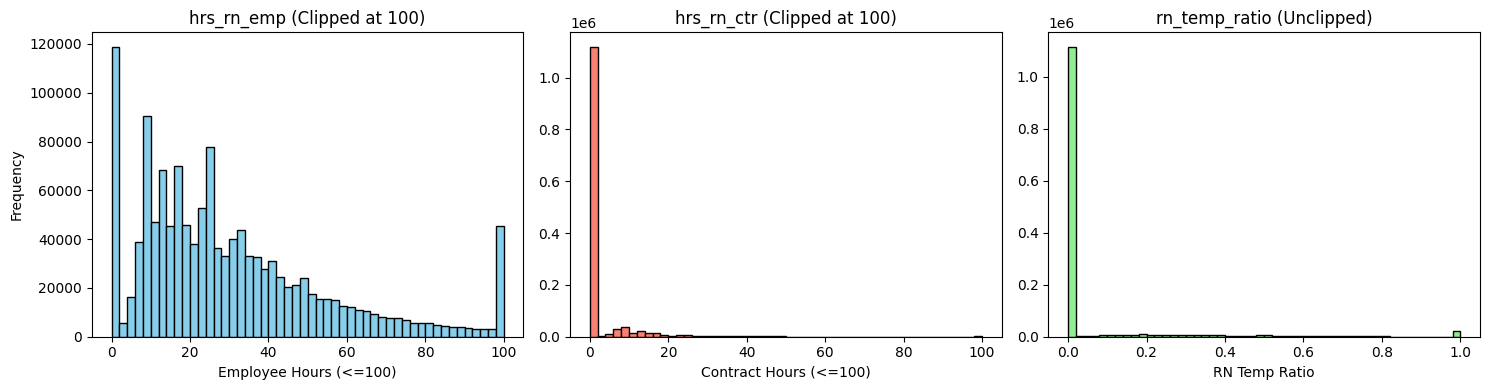

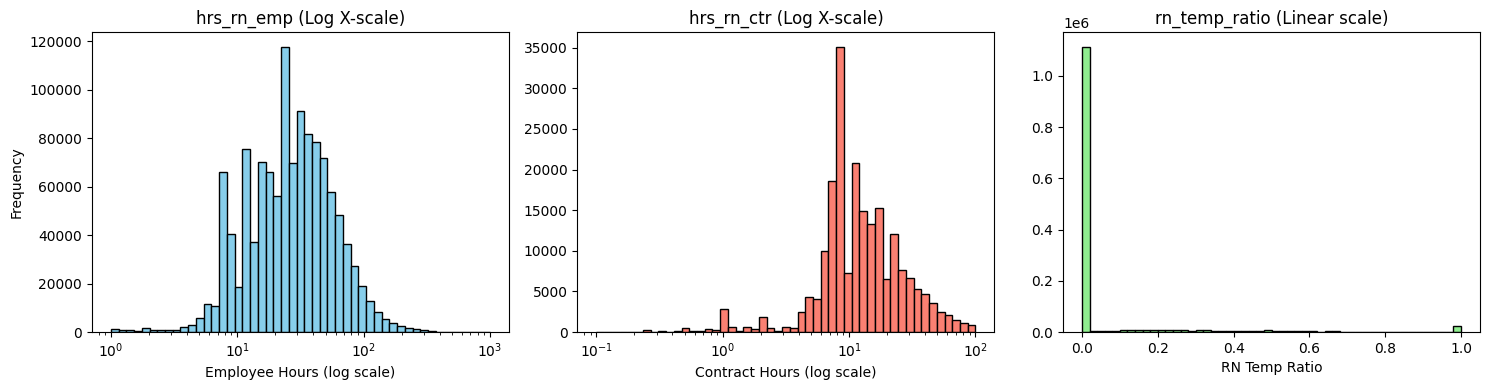

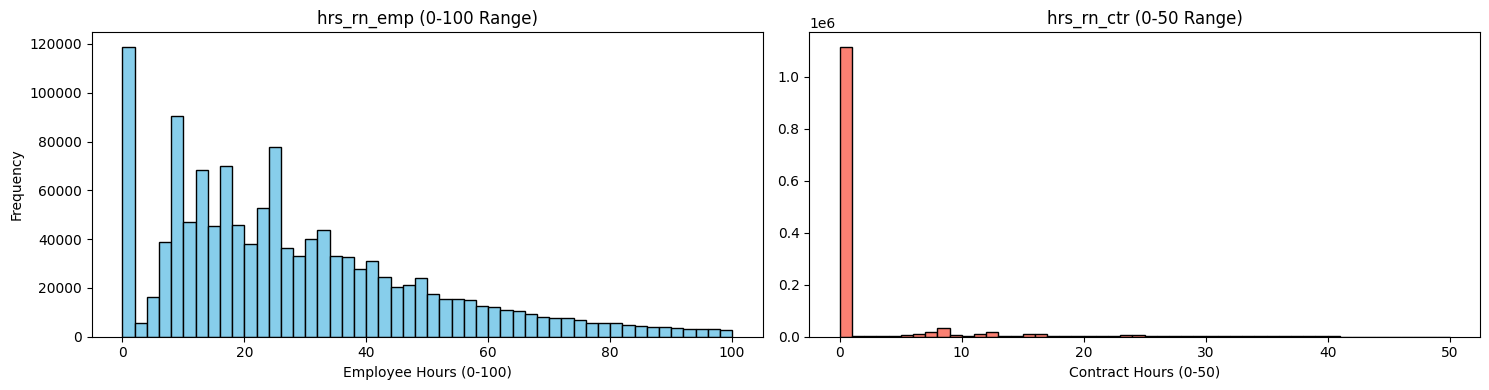

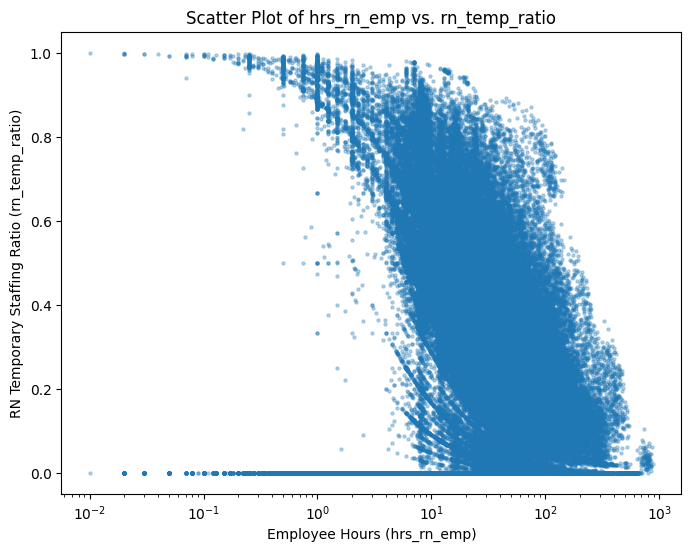

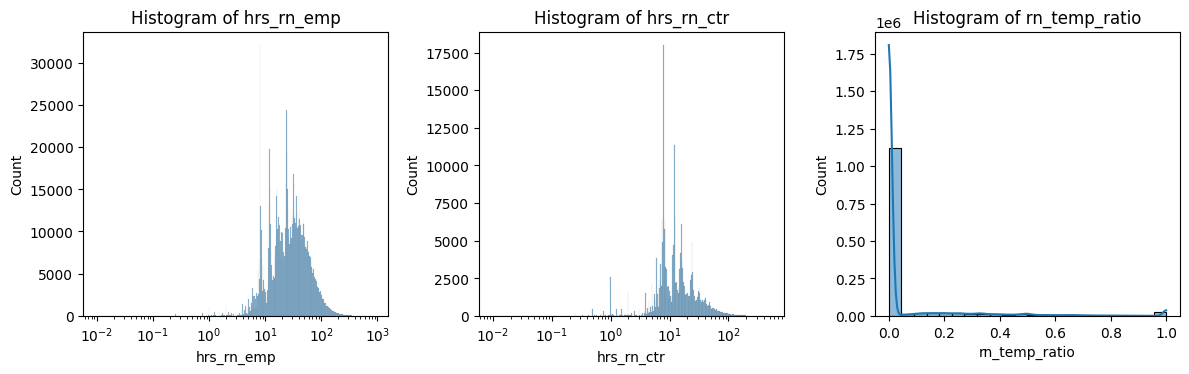

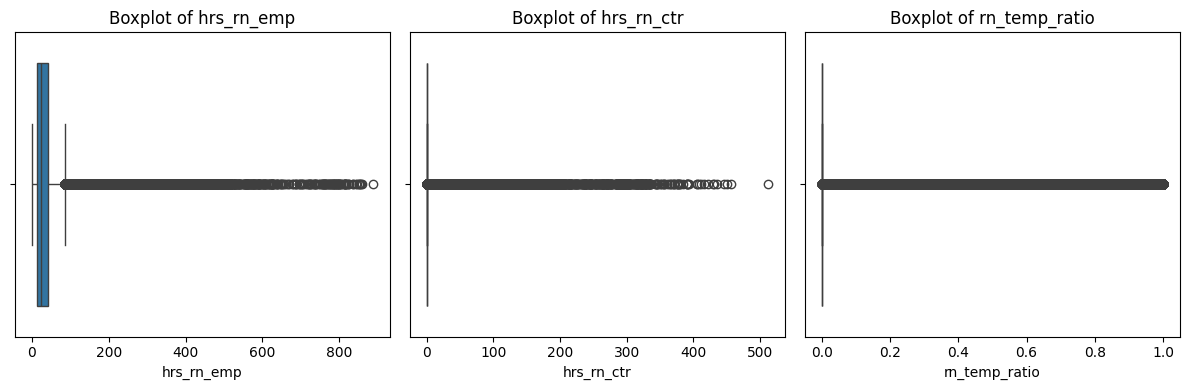

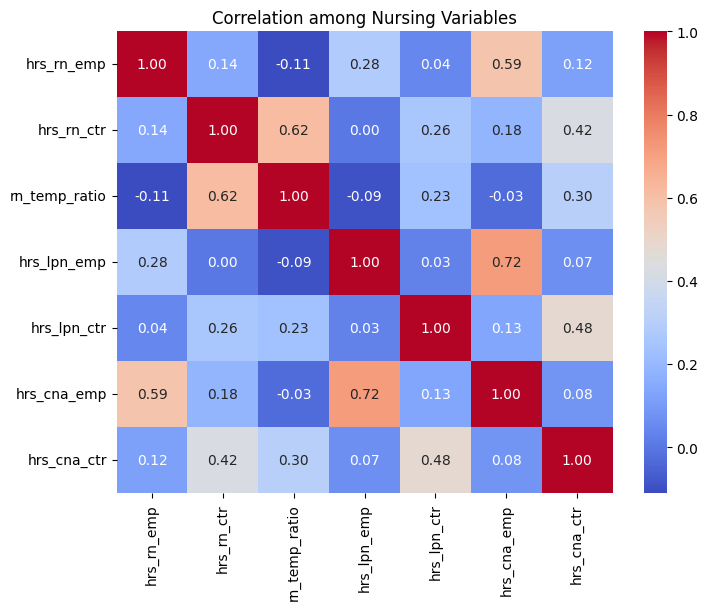

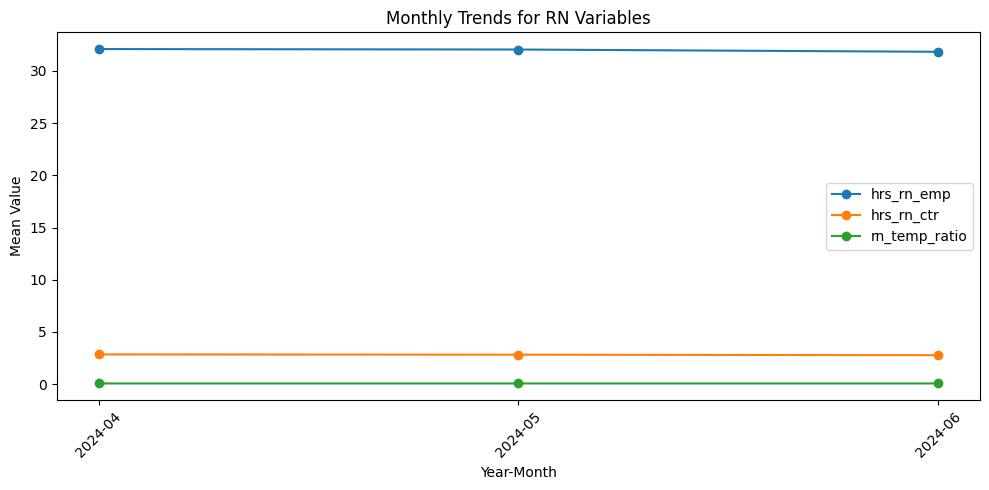

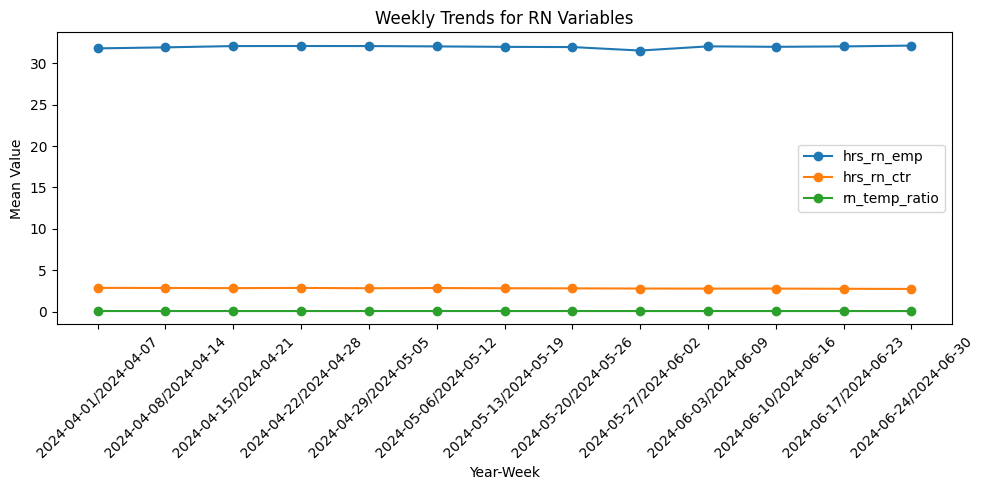

In [1]:
############################################
# RN vs Temp Ratio Analysis 
############################################

import logging
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

########################################
# 0) LOGGING SETUP
########################################
LOG_FILE = "ratio_variable.log"

logging.basicConfig(
    level=logging.INFO,
    filename=LOG_FILE,
    filemode="w",  # Overwrite previous logs on each run
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger()

# Redirect print statements to the logger
class LoggerWriter:
    def __init__(self, level):
        self.level = level
    def write(self, message):
        if message.strip():
            self.level(message.strip())
    def flush(self):
        pass

sys.stdout = LoggerWriter(logger.info)
sys.stderr = LoggerWriter(logger.error)

print("=== Starting Process Phase Notebook: Logging Setup Complete ===")

########################################
# 1) LOAD PREPARED DATASETS
########################################
PREPARED_PATH = "./data/prepared/"

files = {
    "pbj_nurse": "pbj_nurse_prepared.parquet",
    "pbj_non_nurse": "pbj_non_nurse_prepared.parquet",
    "qrp_provider": "qrp_provider_prepared.parquet",
    "nh_survey": "nh_survey_prepared.parquet",
    "nh_quality_mds": "nh_quality_mds_prepared.parquet",
    "nh_ownership": "nh_ownership_prepared.parquet",
    "nh_citations": "nh_citations_prepared.parquet"
}

loaded_datasets = {}
for key, filename in files.items():
    file_path = os.path.join(PREPARED_PATH, filename)
    try:
        loaded_datasets[key] = pd.read_parquet(file_path)
        print(f"Loaded {key} with shape {loaded_datasets[key].shape}")
    except Exception as e:
        print(f"Error loading {key}: {e}")

# Optionally, check columns for pbj_nurse
print("Columns in pbj_nurse:", loaded_datasets['pbj_nurse'].columns.tolist())

########################################
# 2) DERIVE RN TEMPORARY STAFFING RATIO
########################################
df_nurse = loaded_datasets['pbj_nurse'].copy()

required_columns = ['hrs_rn_ctr', 'hrs_rn_emp']
if all(col in df_nurse.columns for col in required_columns):
    # rn_temp_ratio = hrs_rn_ctr / (hrs_rn_emp + hrs_rn_ctr + 1e-6)
    df_nurse['rn_temp_ratio'] = df_nurse['hrs_rn_ctr'] / (df_nurse['hrs_rn_emp'] + df_nurse['hrs_rn_ctr'] + 1e-6)
    print("Calculated 'rn_temp_ratio' for PBJ Nurse dataset.")
else:
    print("Required columns for RN ratio calculation are missing.")

# Display the first 5 rows of relevant columns
print(df_nurse[['hrs_rn_emp', 'hrs_rn_ctr', 'rn_temp_ratio']].head())

# Update our dataset in the dictionary
loaded_datasets['pbj_nurse'] = df_nurse

########################################
# 3) HISTOGRAMS & BASIC VISUALIZATIONS
########################################
print("\n=== BASIC HISTOGRAMS & VISUALIZATIONS ===")

# Example: Clipping high values for visualization
df_nurse_clipped = df_nurse.copy()
df_nurse_clipped['hrs_rn_emp'] = df_nurse_clipped['hrs_rn_emp'].clip(upper=100)
df_nurse_clipped['hrs_rn_ctr'] = df_nurse_clipped['hrs_rn_ctr'].clip(upper=100)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(df_nurse_clipped['hrs_rn_emp'], bins=50, color='skyblue', edgecolor='black')
plt.title('hrs_rn_emp (Clipped at 100)')
plt.xlabel('Employee Hours (<=100)')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.hist(df_nurse_clipped['hrs_rn_ctr'], bins=50, color='salmon', edgecolor='black')
plt.title('hrs_rn_ctr (Clipped at 100)')
plt.xlabel('Contract Hours (<=100)')

plt.subplot(1,3,3)
plt.hist(df_nurse['rn_temp_ratio'], bins=50, color='lightgreen', edgecolor='black')
plt.title('rn_temp_ratio (Unclipped)')
plt.xlabel('RN Temp Ratio')

plt.tight_layout()
plt.show()

# Log-Scale histograms
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(df_nurse['hrs_rn_emp'], bins=np.logspace(0, 3, 50), color='skyblue', edgecolor='black')
plt.xscale('log')
plt.title('hrs_rn_emp (Log X-scale)')
plt.xlabel('Employee Hours (log scale)')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.hist(df_nurse['hrs_rn_ctr'], bins=np.logspace(-1, 2, 50), color='salmon', edgecolor='black')
plt.xscale('log')
plt.title('hrs_rn_ctr (Log X-scale)')
plt.xlabel('Contract Hours (log scale)')

plt.subplot(1,3,3)
plt.hist(df_nurse['rn_temp_ratio'], bins=50, color='lightgreen', edgecolor='black')
plt.title('rn_temp_ratio (Linear scale)')
plt.xlabel('RN Temp Ratio')

plt.tight_layout()
plt.show()

# Zoomed-in histograms
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.hist(df_nurse['hrs_rn_emp'], bins=50, range=(0,100), color='skyblue', edgecolor='black')
plt.title('hrs_rn_emp (0-100 Range)')
plt.xlabel('Employee Hours (0-100)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(df_nurse['hrs_rn_ctr'], bins=50, range=(0,50), color='salmon', edgecolor='black')
plt.title('hrs_rn_ctr (0-50 Range)')
plt.xlabel('Contract Hours (0-50)')

plt.tight_layout()
plt.show()

########################################
# 4) EXTREME OUTLIER ANALYSIS
########################################
print("\n=== EXTREME OUTLIER ANALYSIS FOR RN STAFFING VARIABLES ===")

variables = ['hrs_rn_emp', 'hrs_rn_ctr', 'rn_temp_ratio']

# For each variable, compute percentiles and count extreme outliers (above 99th percentile)
for var in variables:
    data = df_nurse[var]
    percentiles = np.percentile(data, [0, 25, 50, 75, 90, 95, 99, 100])
    print(f"Summary percentiles for {var}: {percentiles}")
    
    # Define extreme outliers as those above the 99th percentile
    threshold = percentiles[6]
    outlier_count = (data > threshold).sum()
    print(f"Number of extreme outliers for {var} (above 99th percentile = {threshold}): {outlier_count}\n")

# Scatter plot: Employee hours vs. RN Temporary Staffing Ratio
plt.figure(figsize=(8,6))
plt.scatter(df_nurse['hrs_rn_emp'], df_nurse['rn_temp_ratio'], alpha=0.3, s=5)
plt.xlabel("Employee Hours (hrs_rn_emp)")
plt.ylabel("RN Temporary Staffing Ratio (rn_temp_ratio)")
plt.title("Scatter Plot of hrs_rn_emp vs. rn_temp_ratio")
plt.xscale('log')
plt.show()

########################################
# 5) IN-DEPTH ANALYSIS & TIME-SERIES
########################################
print("\n=== IN-DEPTH ANALYSIS (Outliers, Facility-Level, Correlation, Time-Series) ===")

# 5.1 Extreme Outlier Detection (recap)
variables = ['hrs_rn_emp', 'hrs_rn_ctr', 'rn_temp_ratio']
thresholds = {}
for var in variables:
    threshold_99 = np.percentile(df_nurse[var], 99)
    thresholds[var] = threshold_99

    outlier_count = (df_nurse[var] > threshold_99).sum()
    print(f"Variable: {var}\n  99th percentile: {threshold_99:.2f}\n  # of outliers > 99th percentile: {outlier_count}\n")

# 5.2 Exploratory Data Analysis (Histograms, Boxplots)
print("=== EDA (Histograms & Boxplots) ===")
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, var in enumerate(variables, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_nurse[var], kde=True, log_scale=(True, False) if var != 'rn_temp_ratio' else False)
    plt.title(f"Histogram of {var}")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, var in enumerate(variables, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df_nurse[var])
    plt.title(f"Boxplot of {var}")
plt.tight_layout()
plt.show()

# 5.3 Facility-Level Analysis
print("=== Facility-Level Analysis ===")
facility_stats = (
    df_nurse
    .groupby('provnum')
    .agg(
        avg_rn_temp_ratio=('rn_temp_ratio', 'mean'),
        total_rn_ctr=('hrs_rn_ctr', 'sum'),
        total_rn_emp=('hrs_rn_emp', 'sum')
    )
    .reset_index()
)

top_ratio_facilities = facility_stats.sort_values('avg_rn_temp_ratio', ascending=False).head(10)
print("Top 10 Facilities by Average RN Temporary Staffing Ratio:\n", top_ratio_facilities, "\n")

top_contract_facilities = facility_stats.sort_values('total_rn_ctr', ascending=False).head(10)
print("Top 10 Facilities by Total RN Contract Hours:\n", top_contract_facilities, "\n")

# 5.4 Correlation with Other Nursing Variables
print("=== Correlation with LPN, CNA, etc. ===")
nursing_cols = [
    'hrs_rn_emp', 'hrs_rn_ctr', 'rn_temp_ratio',
    'hrs_lpn_emp', 'hrs_lpn_ctr', 'hrs_cna_emp', 'hrs_cna_ctr'
]
corr_matrix = df_nurse[nursing_cols].corr()
print("Correlation Matrix:\n", corr_matrix, "\n")

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation among Nursing Variables")
plt.show()

# 5.5 Advanced Outlier Profiling
print("=== Advanced Outlier Profiling ===")
emp_cut = thresholds['hrs_rn_emp']
ctr_cut = thresholds['hrs_rn_ctr']
ratio_cut = thresholds['rn_temp_ratio']

outlier_condition = (
    (df_nurse['hrs_rn_emp'] > emp_cut) |
    (df_nurse['hrs_rn_ctr'] > ctr_cut) |
    (df_nurse['rn_temp_ratio'] > ratio_cut)
)

df_outliers = df_nurse[outlier_condition].copy()
print(f"Total outlier rows (top 1% by any metric): {len(df_outliers)}")

if 'state' in df_outliers.columns:
    outlier_by_state = (
        df_outliers
        .groupby('state')
        .agg(
            count=('provnum','count'),
            avg_rn_ratio=('rn_temp_ratio','mean')
        )
        .sort_values('count', ascending=False)
    )
    print("Outlier Facilities by State (Count & Avg RN Temp Ratio):\n", outlier_by_state.head(10), "\n")
else:
    print("No 'state' column found in df_outliers; skipping state-based grouping.")

# 5.6 Time-Series Analysis
print("\n=== TIME-SERIES ANALYSIS ===")

# Ensure 'workdate' is datetime
if 'workdate' in df_nurse.columns:
    df_nurse['workdate'] = pd.to_datetime(df_nurse['workdate'], errors='coerce')
else:
    print("No 'workdate' column found, skipping time-series.")

# (A) Monthly
if 'workdate' in df_nurse.columns:
    df_nurse['year_month'] = df_nurse['workdate'].dt.to_period('M')
    monthly_trends = (
        df_nurse
        .groupby('year_month')[variables]
        .mean()
        .reset_index()
    )

    print("\nMonthly Trends (Mean):\n", monthly_trends.head())

    # (B) Weekly
    df_nurse['year_week'] = df_nurse['workdate'].dt.to_period('W')
    weekly_trends = (
        df_nurse
        .groupby('year_week')[variables]
        .mean()
        .reset_index()
    )

    print("\nWeekly Trends (Mean):\n", weekly_trends.head())

    # Plot monthly trends
    fig, ax = plt.subplots(figsize=(10,5))
    for var in variables:
        ax.plot(
            monthly_trends['year_month'].astype(str),
            monthly_trends[var], marker='o', label=var
        )
    ax.set_title("Monthly Trends for RN Variables")
    ax.set_xlabel("Year-Month")
    ax.set_ylabel("Mean Value")
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot weekly trends
    fig, ax = plt.subplots(figsize=(10,5))
    for var in variables:
        ax.plot(
            weekly_trends['year_week'].astype(str),
            weekly_trends[var], marker='o', label=var
        )
    ax.set_title("Weekly Trends for RN Variables")
    ax.set_xlabel("Year-Week")
    ax.set_ylabel("Mean Value")
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("\n=== ANALYSIS COMPLETE ===")
